### 使用GCN和LSTM对API call sequence进行malware检测



In [253]:
!pip install skorch

import numpy as np
SEED = 137
np.random.seed(SEED)

import time
from collections import Counter

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.metrics import precision_score, f1_score, roc_auc_score, roc_curve
from sklearn import decomposition

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import torch
torch.manual_seed(SEED)
import torch.nn as nn
import torch.nn.functional as F

from skorch.classifier import NeuralNetBinaryClassifier

import matplotlib.pyplot as plt
from matplotlib import pyplot

### 数据预处理


In [254]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/L14/")
# 数据加载
df = pd.read_csv('dynamic_api_call_sequence_per_malware_100_0_306.csv')
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                               hash  t_0  t_1  t_2  ...  t_97  t_98  t_99  malware
0  071e8c3f8922e186e57548cd4c703a5d  112  274  158  ...   208    56    71        1
1  33f8e6d08a6aae939f25a8e0d63dd523   82  208  187  ...   171   215    35        1
2  b68abd064e975e1c6d5f25e748663076   16  110  240  ...    65   113   112        1
3  72049be7bd30ea61297ea624ae198067   82  208  187  ...   302   228   302        1
4  c9b3700a77facf29172f32df6bc77f48   82  240  117  ...   260   141   260        1

[5 rows x 102 columns]


In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43876 entries, 0 to 43875
Columns: 102 entries, hash to malware
dtypes: int64(101), object(1)
memory usage: 34.1+ MB


In [256]:
# 得到特征X和目标y
X = df.drop(['hash', 'malware'], axis = 1).values.astype(int)
y = df['malware'].values.astype(int)
print(X.shape)
print(y.shape)

(43876, 100)
(43876,)


In [257]:
# 数据探索，说明X特征矩阵取值为0-306
print(X.min())
print(X.max())

0
306


In [0]:
# 检查样本是否均匀
def check_imbalance(dataset):
    count = sorted(Counter(dataset).items())
    print(count)
    print(count[1][1] / count[0][1])
    return

In [259]:
check_imbalance(y)

[(0, 1079), (1, 42797)]
39.66357738646895


In [0]:
# 训练集70%，测试集30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

In [261]:
check_imbalance(y_train)
check_imbalance(y_test)
# 释放不用的变量
del df, X, y

[(0, 731), (1, 29982)]
41.015047879616965
[(0, 348), (1, 12815)]
36.82471264367816


#### 定义GCN模型


In [0]:
# 计算邻近矩阵A和D矩阵
def norn_adj(X, input_dim_1):
    # batch_size, input_dim_1, input_dim_1
    temp = X.cpu().numpy()
    A_adj = np.zeros([X.size(0), input_dim_1, input_dim_1])

    for i in range(temp.shape[0]):
      for j in range(temp.shape[1]):
        x1 = int(temp[i,j])
        if j!=(temp.shape[1]-1):
          x2 = int(temp[i,j+1])
          A_adj[i][x1][x2] = 1.0
          #print(A_adj[i][x1][x2])
    A = torch.from_numpy(A_adj).float().cuda()

    # A_hat为A和单位矩阵之和
    A_hat = A + torch.eye(input_dim_1, dtype = torch.float).cuda()
    D_hat = A_hat.sum(dim = 1).pow(-1.0).diag_embed()    
    return A_hat, D_hat

# 对X进行one_hot特征提取
def to_one_hot(X, input_dim_1):    
    X = F.one_hot(X, num_classes = input_dim_1).float()    
    X = X.permute(0, 2, 1)    
    return X

class GCN_network(nn.Module):    
    def __init__(self, weight_dim_1, weight_dim_2):
        super(GCN_network, self).__init__()
        self.weight_dim_1 = weight_dim_1
        self.weight_dim_2 = weight_dim_2        
        # 权重随机生成，y=wx+b里那个w
        self.weights = nn.Parameter(torch.rand((self.weight_dim_1, weight_dim_2), dtype = torch.float, requires_grad = True))
        
    def forward(self, A_hat, D_hat, X):
        return D_hat.matmul(A_hat).matmul(X).matmul(self.weights)

#### 定义GCN网络(model_1)


In [0]:
# 使用1层GCN层
H_list_model_1 = []
class Model_1_network(nn.Module):    
    def __init__(self, input_dim_1, input_dim_2, weight_dim_2, dropout_rate):        
        super(Model_1_network, self).__init__()
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.weight_dim_1 = input_dim_2
        self.weight_dim_2 = weight_dim_2
        self.dropout_rate = dropout_rate
        # 定义GCN层，AX其实理解成X中每个节点对周围的加权，然后再过线性变换
        self.gcn = GCN_network(self.weight_dim_1, self.weight_dim_2)
        # 定义dropout
        self.dropout = nn.Dropout(p = self.dropout_rate)
        # 定义FC层,从隐层到1维
        self.fc = nn.Linear(self.input_dim_1 * self.weight_dim_2, 1)
    # 前向传播
    def forward(self, X):
        # 通过X得到A_hat, D_hat
        A_hat, D_hat = norn_adj(X, input_dim_1)
        X = to_one_hot(X, input_dim_1)
        # 将A_hat, D_hat, X作为输入，传入GCN层
        H = self.gcn(A_hat, D_hat, X)
        H = self.dropout(H)
        H = torch.relu(H)
        # 变成两维,第一个维度保持不变,后面的很多维全部变成一维
        H = H.view(H.size(0), -1)    
        # Visualization
        if not self.training:
            H_list_model_1.append(H.cpu())        
        H = self.fc(H)                
        return H.squeeze()

#### 定义LSTM模型

In [0]:
H_list_lstm = []
# 定义LSTM
class LSTM_network(nn.Module):    
    def __init__(self, input_dim, hidden_dim, dropout_rate):        
        super(LSTM_network, self).__init__()        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, batch_first = True)
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.hidden_dim, 1)
    # 前向传播
    def forward(self, X):       
        # 对X进行one_hot特征提取 
        X = F.one_hot(X, num_classes = self.input_dim).float().cuda()        
        # 隐藏层形状：(num_layers, batch_size, hidden_dim)
        hidden_0 = (torch.zeros(1, X.size(0), self.hidden_dim).float().cuda(),
                    torch.zeros(1, X.size(0), self.hidden_dim).float().cuda()) 
        # 输入/输出形状：(batch_size, seq_len, input_dim)
        _, self.hidden = self.lstm(X, hidden_0)                
        H = self.hidden[0].squeeze()
        H = self.dropout(H)
        
        # 可视化时用到
        H_list_lstm.append(H.cpu())        
        H = self.fc(H)                
        return H.squeeze()

### 模型评估

In [0]:
# 模型评估
def model_evaluate(y, pred):
    print('Confusion matrix\n[TN FP]\n[FN TP]')
    # confusion_matrix(y_true, y_pred)
    print(confusion_matrix(y >= 0.5, pred >= 0.5))
    print(f'F1-Score: {f1_score(y >= 0.5, pred >= 0.5):.4f}')
    print(f'ROC AUC: {roc_auc_score(y, pred):.4f}')
    return

#### LSTM网络

In [266]:
torch.manual_seed(SEED)
# LSTM超参数设置
input_dim = 307
hidden_dim = 70
dropout_rate = 0.5
batch_size = 128
max_epochs = 2
# 使用LSTM做二分类
LSTM = NeuralNetBinaryClassifier(
    LSTM_network,
    module__input_dim = input_dim,
    module__hidden_dim = hidden_dim,
    module__dropout_rate = dropout_rate,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_split = None,
    optimizer = torch.optim.Adam,
    iterator_train__shuffle = True,
    device = 'cuda'
)
# 定义Pipeline
pipe = Pipeline([
    ('model', LSTM)
])
# 使用LSTM进行训练
pipe.fit(X_train, y_train.astype(np.float))

  epoch    train_loss     dur
-------  ------------  ------
      1        0.1165  2.5891
      2        0.0817  2.5143


Pipeline(memory=None,
         steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=LSTM_network(
    (lstm): LSTM(307, 70, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=70, out_features=1, bias=True)
  ),
))],
         verbose=False)

In [267]:
H_list_lstm.clear()
# 得到预测结果
X_test_predictions_1 = pipe.predict_proba(X_test)[:,1]
model_evaluate(y_test, np.ones(len(y_test)))
print(X_test_predictions_1)
print(y_test)
# 对LSTM预测结果进行评估
model_evaluate(y_test, X_test_predictions_1)

Confusion matrix
[TN FP]
[FN TP]
[[    0   348]
 [    0 12815]]
F1-Score: 0.9866
ROC AUC: 0.5000
[0.9980738  0.99557084 0.86048406 ... 0.9956494  0.9793529  0.99587256]
[1 1 1 ... 1 1 1]
Confusion matrix
[TN FP]
[FN TP]
[[   60   288]
 [    1 12814]]
F1-Score: 0.9888
ROC AUC: 0.8788


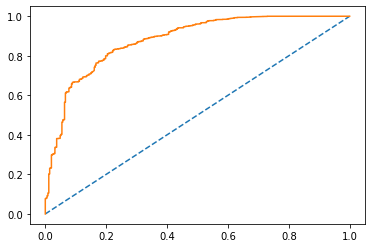

In [268]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, X_test_predictions_1)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_1, tpr_1)
pyplot.show()

In [0]:
# 可视化
def visualize(X, y, points, n_features):
    # points随机排列
    points = np.arange(points)
    np.random.shuffle(points)
    color = ['red' if l == 1 else 'green' for l in y[points]]
    for i in range(n_features):
        for j in range(n_features):
            if j > i:
                plt.scatter(X[points, i], X[points, j], color = color)
                plt.pause(0.1)
    return

In [0]:
# 使用PCA压缩到2维，进行可视化
def visualize_pca(X, y):
    # 归一化
    X = X / np.max(X)
    # 使用PCA进行压缩
    pca = decomposition.PCA(n_components = 2)
    # 可视化
    visualize(pca.fit_transform(X), y, X.shape[0], 2)
    return

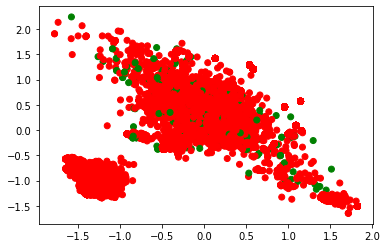

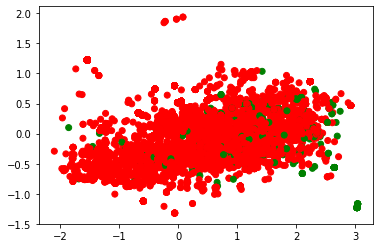

In [271]:
visualize_pca(X_test, y_test)
result = torch.zeros(1, 70)
for i in H_list_lstm:
    result = torch.cat([result, i.cpu()], 0)

X_result = result.numpy()[1:]
visualize_pca(X_result, y_test)

#### 使用GCN网络进行学习


In [272]:
torch.manual_seed(SEED)
# 输入dim=307
input_dim_1 = 307
# GCN dim=100
input_dim_2 = 100
weight_dim_2 = 31
dropout_rate = 0.6
batch_size = 128
max_epochs = 10
# 使用GCN做二分类
model_1 = NeuralNetBinaryClassifier(
    Model_1_network,
    module__input_dim_1 = input_dim_1,
    module__input_dim_2 = input_dim_2,    
    module__weight_dim_2 = weight_dim_2,
    module__dropout_rate = dropout_rate,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_split = None,
    optimizer = torch.optim.Adam,
    iterator_train__shuffle = True,
    device = 'cuda'
)

pipe = Pipeline([
    ('model', model_1)
])

pipe.fit(X_train, y_train.astype(np.float))

  epoch    train_loss      dur
-------  ------------  -------
      1        0.1694  16.9032
      2        0.0458  15.8949
      3        0.0379  16.1111
      4        0.0319  15.8425
      5        0.0290  15.9813
      6        0.0285  15.8594
      7        0.0266  15.9151
      8        0.0240  15.9196
      9        0.0248  15.9263
     10        0.0232  15.9795


Pipeline(memory=None,
         steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=Model_1_network(
    (gcn): GCN_network()
    (dropout): Dropout(p=0.6, inplace=False)
    (fc): Linear(in_features=9517, out_features=1, bias=True)
  ),
))],
         verbose=False)

In [273]:
H_list_model_1.clear()

X_test_predictions_2 = pipe.predict_proba(X_test)[:,1]
model_evaluate(y_test, np.ones(len(y_test)))
model_evaluate(y_test, X_test_predictions_2)

Confusion matrix
[TN FP]
[FN TP]
[[    0   348]
 [    0 12815]]
F1-Score: 0.9866
ROC AUC: 0.5000
Confusion matrix
[TN FP]
[FN TP]
[[  210   138]
 [   15 12800]]
F1-Score: 0.9941
ROC AUC: 0.9737


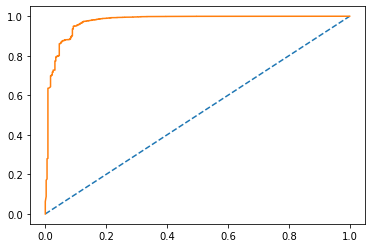

In [274]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, X_test_predictions_2)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_2, tpr_2)
pyplot.show()

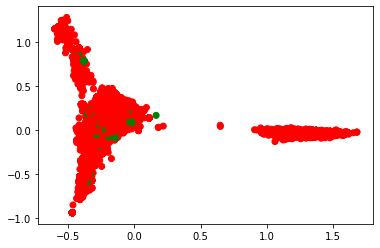

In [275]:
result = torch.zeros(1, 9517)
for i in H_list_model_1:
    result = torch.cat([result, i.cpu()], 0)
X_result = result.numpy()[1:]
visualize_pca(X_result, y_test)